# Initial Value Problems for Ordinary Differential Equations, Part 5: Error Control and Variable Step Sizes

**Version of April 17, 2021**,
- revising the description of the step control method; it is better to only apply the "safety factor" when choosing the next step size; not when checking whether the current step is accurtate enough, and
- adding Python code and examples for error control in Euler's method.

Previous additions on April 7 include
- the fourth-order accurate Runge-Kutta Fehlberg method,
- an example with an ODE IVP solver from package SciPy, the function `scipy.integrate.solve_ivp`, and
- an illustration of how to measure the time taken to execute a piece of code, using the function `time.time`.

**References:**

- Section 6.5 *Variable Step-Size Methods* in [Sauer](../references.html#Sauer)
- Section 5.5 *Error Control and the Runge-Kutta-Fehlberg Method* in [Burden&Faires](../references.html#Burden-Faires)
- Section 7.3 of [Chenney&Kincaid](../references.html#Chenney-Kincaid)

## The Basic ODE Initial Value Problem

We consider again the initial value problem

$$
\frac{d u}{d t} = f(t, u) \quad a \leq t \leq b, \quad u(a) = u_0
$$

We now allow the possibility that $u$ and $f$ are vector-valued as in the section on
[Systems of ODEs and Higher Order ODEs](ODE-IVP-4-system-higher-order-equations.ipynb),
but omitting the tilde notation $\tilde u$, $\tilde f$.

## Error Control by Varying the Time Step Size $h_i$

Recall the variable step-size version of Euler's method:

Input: $f$, $a$, $b$, $n$ <br>

$t_0 = a$ <br>
$U_0 = u_0$ <br>
$h = (b-a)/n$ <br>

for i in $[0, n)$:
<br>

$\qquad$ Choose step size $h_i$ somehow!
<br>

$\qquad$ $t_{i+1} = t_i + h_i$
<br>

$\qquad$ $U_{i+1} = U_i + h_i f(t_i, U_i)$
<br>

end for

We now consider how to choose each step size, by estimating the error in each step, and aiming to have error per unit time below some limit like $\epsilon/(b-a)$, so that the global error is no more than about $\epsilon$.

As usual, the theoretical error bounds like $O(h_i^2)$ for a single step of Euler's method are not enough for quantitative tasks like choosing $h_i$, but they do motivate more practical estimates.

## A crude error estimate for Euler's Method: Richardson Extrapolation

Starting at a point (t, u(t)), we can estimate the error in Euler's method approximato at a slightly later time $t_i + h$ by using two approximations of $U(t + h)$:
- The value given by a step of Euler's method with step size $h$: call this $U^{h}$
- The value given by taking two steps of Euler's method each with step size $h/2$: call this $U_2^{h/2}$,
because it involves 2 steps of size $h/2$.

The first order accuracy of Euler's method gives $e_h = u(t+h) - U^{h} \approx 2(u(t+h) - U_2^{h/2})$,
so that

$$e_h \approx \frac{U_2^{h/2} - U^{h}}{2}$$

### Step size choice

What do we do with this error information?

The first obvious ideas are:
- Accept this step if $e_h$ is small enough, taking $h_i = h$, $t_{i+1} = t_i + h_i$, and $U_{i+1} = U^h$, but
- reject it and try again with a smaller $h$ value otherwise; maybe halving $h$; but there are more sophisticated options too.

### Exercise 1

Write a formula for $U_h$ and $e_h$ if one starts from the point $(t_i, U_i)$, so that $(t_i + h, U^h)$ is the proposed value for the next point $(t_{i+1}, U_{i+1})$ in the approximate solution — but only if $e_h$ is small enough!

### Error tolerance 

One simple criterion for accuracy is that the estimated error in this step be no more than some overall upper limit on the error in each time step, $T$.
That is, accept the step size $h$ if

$$|e_h| \leq T$$

### A crude approach to reducing the step size when needed

If this error tolerance is not met, we must choose a new step size $h'$, and we can predict roughly its error behavior using the known order natue of the error in Euler's method: scaling dowen to $h' = s h$, the error in a single step scales with $h^2$ (in general it scales with $h^{p+1}$ for a method of order $p$), and so to reduce the error by the needed factor $\displaystyle \frac{e_h}{T}$ one needs approximately

$$
s^2 = \frac{T}{|e_h|}
$$

and so using $e_h \approx \tilde{e}_h = |U^{h/2} - U^{h}|$ suggests using

$$s = \left( \frac{T}{|U^{h/2} - U^{h}|} \right)^{1/2}$$

However this new step size might have error that is still slightly too large, leading to a second failure.
Another is that one might get into an infinite loop of step size reduction.

So refinements of this choice must be considered.

### Increasing the step size when desirable

If we simply follow the above aproach, the step size, once reduced, will never be increased.
This could lead to great inefficiency, through using an unecessarily small step size just because at an earlier part of the time domain, accuracy required very small steps.

Thus, after a successful time step, one might consider increasing $h$ for the next step.
This could be done using exactly the above formula, but again there are risks, so again refinement of this choice must be considered.

One problem is that if the step size gets too large, the error estimate can become unreliable; another is that one might need some minimum "temporal resolution", for nice graphs and such.

Both suggest imposing an upper limit on the step size $h$.

## Another strategy for getting error estimates: two (related) Runge-Kutta methods

The recurring strategy of estimating errors by the difference of two different approximations — one expected to be far better than the other — can be used in a nice way here.
I will first illustrate with the simplset version, using Euler's Mathod and the Explicit Trapezoid Method.

Recall that the increment in Euler's Method from time $t$ to time $t+h$ is

$$K_1 = h f(t, U)$$

whereas for the Explict Trapezoid Method it is $(K_1 + K_2)/2$, as given by

$$\begin{split}
K_1 &= h f(t, U)
\\
K_2 &= h f(t+h, U + K_1)
\end{split}$$

Thus we can use the difference, $|K_1 - (K_1 + K_2)/2| = |(K_1 - K_2)/2|$ as an error estimate.
In fact to be cautious, one often drops the factor of $1/2$, so using approximation $\tilde{e}_h = |K_1 - K_2|$.

One has to be careful: this estimates the error in Euler's Method, and one has to use it that way:
using the less accurate value $K_1$ as the update.

A basic algorithm for the time step starting with $t_i, U_i$ is

$K_1 \leftarrow h f(t_i, U_i)$

$K_2 \leftarrow f(t_i + h, U_i + K_1)$

$e_h \leftarrow |K_1 - K_2|$

$s \leftarrow \sqrt{T/e_h}$

if $e_h < T$

$\quad U_{i+1} = U_i + K_1$

$\quad t_{i+1} = t_i + h$

$\quad$ Increase $h$ for the *next* time step:

$\quad h \leftarrow s h$

else:  $\quad$ (not good enough: reduce $h$ and try again)

$\quad h \leftarrow s h$

$\quad$ Start again from $K_1 = \dots$

end if

However, in practice one needs:

- An upper limit $h_{max}$ on the step size $h$, partly because error estimates become unreliable if $h$ gets too large,
and also becuase subsequent use of the results (like graphs) might need sufficiently "fine" data.

- A lower limit $h_{max}$ on $h$, to avoid infinite loops and such.

- Since we are using only an approximation $\tilde{e}_h$ of $e_h$, and out of general caution,
it is typical to include a "safety factor" of about $0.8$ or $0.9$, when computing the *next* time step: reducing the step size scale factor to $S = 0.9 \sqrt{T/e_h}$.

Incorporating these refinements:

$K_1 = h f(t_i, U_i)$

$K_2 = f(t_i+h, U_i + K_1)$

$e_{h} = |K_1 - K_2|$

$s = 0.9\sqrt{T/e_h}$

if $e_h < T$

$\quad U_{i+1} = U_i + K_1$

$\quad t_{i+1} = t_i + h$

$\quad$ Increase $h$ for the *next* time step:

$\quad h \leftarrow \min(0.9 s h, h_{max})$

else: $\quad$ (not good enough; reduce $h$ and try again)

$\quad h \leftarrow \max(0.9 s h, h_{min})$

$\quad$ Start again from $K_1 = \dots$

end if

### Exercise 2

Implement the above, and test on the two familiar examples

$$
\begin{split}
du/dt &= Ku
\\
&\text{and}
\\
du/dt &= K(\cos(t) - u) - \sin(t)
\end{split}
$$

($K=1$ is enough.)

#### Partial Solution to Exercise 2

In [1]:
import numpy as np
from matplotlib.pyplot import figure, plot, title, grid

In [2]:
from numpy import sqrt

def euler_error_control(f, a, b, u_0, errorTolerance=1e-3, h_min=1e-6, h_max=0.1, steps_max=1000, demoMode=False):
    # Use Python lists rather than Numpy arrays; they are easier to "increment"
    # Initialize variables holding the current values of t and U
    steps = 0
    t_i = a
    U_i = u_0
    t = [t_i]
    U = [U_i]
    h = h_max  # Start optimistically!
    while t_i < b and steps < steps_max:
        K_1 = h*f(t_i, U_i)
        K_2 = h*f(t_i + h/2, U_i + K_1/2)
        errorEstimate = abs(K_1 - K_2)
        s = 0.9 * sqrt(errorTolerance/errorEstimate)
        if errorEstimate <= errorTolerance:  # Success!
            t_i += h
            U_i += K_1
            t.append(t_i)
            U.append(U_i)
            # Adjust step size up, but not too big
            h = min(s*h, h_max)
        else:  #Innacurate; reduce step size and try again
            h = max(s*h, h_min)
            if demoMode: print(f"{t_i=}: Decreasing step size to {h:0.3e} and trying again.")
        # A refinement not mentioned above; the next step should not overshoot t=b:
        if t_i + h > b:
            h = b - t_i
        steps += 1
    # Convert out to Numpy arrays, so that they can be used as input to numerical functions and such:
    t = np.array(t)
    U = np.array(U)    
    return (t, U)
    # Note: if the step count ran out, this does not reach t=b, but at least it is correct as fas as it goes

In [3]:
def f(t, U):
    return k*U

In [4]:
k = 1.0
a = 1.0
b = 3.0
u_0 = 2.0
def u(t):
    """Note: the input "t" must be a numpy array or a number; not a Python list."""
    return u_0*np.exp(k*(t-a))

In [5]:
# Get a "stop watch"
# This gives the "wall clock" time in seconds since a reference moment, called "the epoch".
# (For macOS and UNIX, the epoch is the beginning of 1970.)
from time import time

In [6]:
# To read more about the function time.time, run this cell (in the notebook version of this page).
help(time)

Help on built-in function time in module time:

time(...)
    time() -> floating point number
    
    Return the current time in seconds since the Epoch.
    Fractions of a second may be present if the system clock provides them.



t_i=1.0: Decreasing step size to 9.000e-02 and trying again.

With errorTolerance=0.01, this took 36 time steps, of average length 0.0556
The maximum absolute error is 0.831
The maximum absolute error per time step is 0.0231
The time taken to solve was 0.00146 seconds


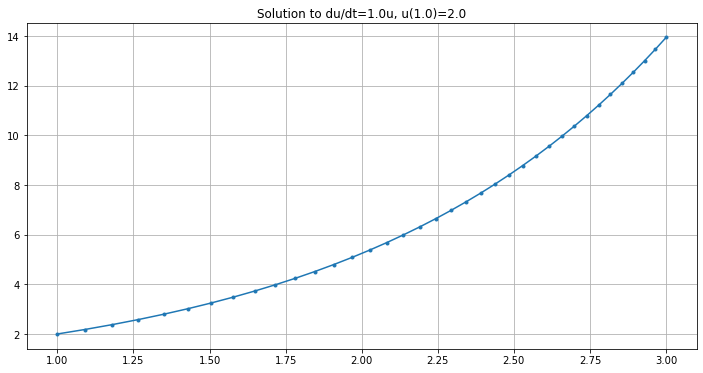

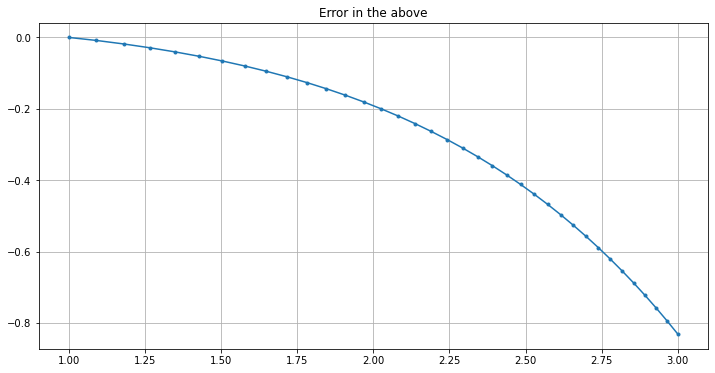

In [7]:
errorTolerance = 1e-2
time_start = time()
(t, U) = euler_error_control(f, a, b, u_0, errorTolerance, demoMode=True)
time_end = time()
time_elapsed = time_end - time_start

steps = len(U) - 1
h_ave = (b-a)/steps
U_exact = u(t)
U_error = U-U_exact
U_max = max(abs(U_error))
print()
print(f"With {errorTolerance=}, this took {steps} time steps, of average length {h_ave:0.3}")
print(f"The maximum absolute error is {U_max:0.3}")
print(f"The maximum absolute error per time step is {U_max/steps:0.3}")
print(f"The time taken to solve was {time_elapsed:0.3} seconds")

figure(figsize=[12,6])
title(f"Solution to du/dt={k}u, u({a})={u_0}")
plot(t, U, ".-")
grid(True)

figure(figsize=[12,6])
title(f"Error in the above")
plot(t, U_error, ".-")
grid(True)

t_i=1.0: Decreasing step size to 2.846e-02 and trying again.

With errorTolerance=0.001, this took 119 time steps, of average length 0.0168
The maximum absolute error is 0.265
The maximum absolute error per time step is 0.00223
The time taken to solve was 0.0149 seconds


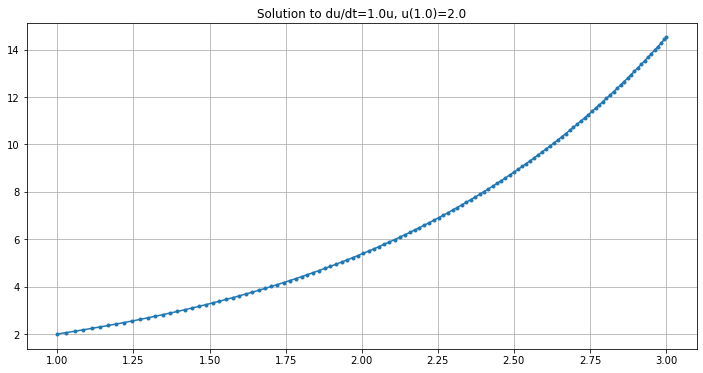

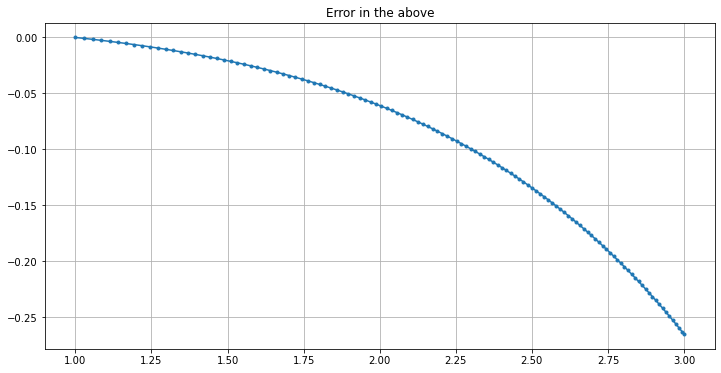

In [8]:
errorTolerance = 1e-3
time_start = time()
(t, U) = euler_error_control(f, a, b, u_0, errorTolerance, demoMode=True)
time_end = time()
time_elapsed = time_end - time_start

steps = len(U) - 1
h_ave = (b-a)/steps
U_exact = u(t)
U_error = U-U_exact
U_max = max(abs(U_error))
print()
print(f"With {errorTolerance=}, this took {steps} time steps, of average length {h_ave:0.3}")
print(f"The maximum absolute error is {U_max:0.3}")
print(f"The maximum absolute error per time step is {U_max/steps:0.3}")
print(f"The time taken to solve was {time_elapsed:0.3} seconds")

figure(figsize=[12,6])
title(f"Solution to du/dt={k}u, u({a})={u_0}")
plot(t, U, ".-")
grid(True)

figure(figsize=[12,6])
title(f"Error in the above")
plot(t, U_error, ".-")
grid(True)

t_i=1.0: Decreasing step size to 9.000e-03 and trying again.

With errorTolerance=0.0001, this took 380 time steps, of average length 0.00526
The maximum absolute error is 0.084
The maximum absolute error per time step is 0.000221
The time taken to solve was 0.0156 seconds


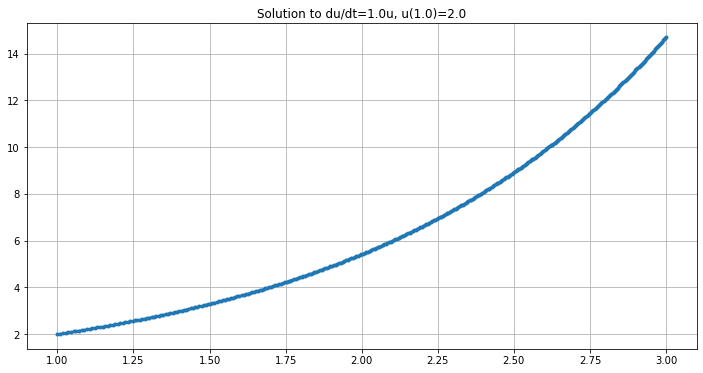

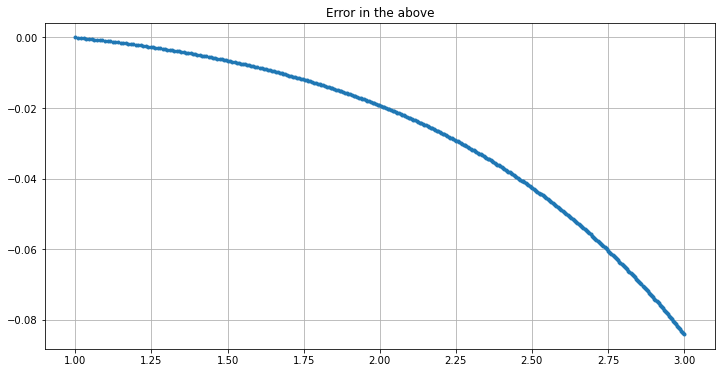

In [9]:
errorTolerance = 1e-4
time_start = time()
(t, U) = euler_error_control(f, a, b, u_0, errorTolerance, demoMode=True)
time_end = time()
time_elapsed = time_end - time_start

steps = len(U) - 1
h_ave = (b-a)/steps
U_exact = u(t)
U_error = U-U_exact
U_max = max(abs(U_error))
print()
print(f"With {errorTolerance=}, this took {steps} time steps, of average length {h_ave:0.3}")
print(f"The maximum absolute error is {U_max:0.3}")
print(f"The maximum absolute error per time step is {U_max/steps:0.3}")
print(f"The time taken to solve was {time_elapsed:0.3} seconds")

figure(figsize=[12,6])
title(f"Solution to du/dt={k}u, u({a})={u_0}")
plot(t, U, ".-")
grid(True)

figure(figsize=[12,6])
title(f"Error in the above")
plot(t, U_error, ".-")
grid(True)

<a name="ETMEC"></a>
## The explicit trapezoid method with error control

In practice, one usually needs at least second order accuracy, and one approach to that is using computing a "candidates" for teh next time step with a second order accurate Runge-Kutta method and also a third order accurate one, the latter used only to get an error estimate for the former.

Perhaps the simplest of these is based on adding error estimation to the Explicit Trapezoid Rule;
omitting the step size adjustment for now, the main ingredients are:

$K_1 = h f(t, U)$

$K_2 = f(t + h, U + K_1)$

(So far, as for the explicit trapezoid method)

$K_3 = f(t + h/2, U + (K_1 + K_2)/2)$

(a midpoint approximation, using the above)

$\delta_2 = (K_1 + K_2)/2$

(The order 2 increment as for the explicit trapezoid method)

$\delta_3 = (K_1 + 4 K_3 + K_2)/6$

(An order 3 increment — note the resemblance to Simpson's Rule for integration.
This is only used to get:)

$e_h = |\delta_2 - \delta_3 |, \, = |K_1 -2 K_3 + K_2|/3$

Again, if this step is accepted, one uses the explicit trapezoid rule step: $U_{i+1} = U_i + \delta_2$.

### Step size adjustment

The scale factor $s$ for step size adjustment must be modified for a method order $p$ (with $p=2$ now):
- Changing step size by a factor $s$ will change the error $e_h$ in a single time step by a factor of about $s^{p+1}$.

- Thus, we want a new step with this rescaled error of about $s^{p+1} e_h$ roughly matching the tolerance $T$.
Equating would give $s^{p+1} e_h = T$, so $s = (T/e_h))^{1/(p+1)}$,
but as noted above, since we are using only an approximation $\tilde{e}_h$ of $e_h$
it is typical to include a "safety factor" of about $0.9$, so something like

$$s = 0.9 \left( \frac{T}{|\tilde{e}_h|} \right)^{1/(p+1)}$$

Thus for this second order accurate method, we then get

$$s = 0.9 \left( \frac{3 T}{|K_1 -2 K_3 + K_2|} \right)^{1/3}$$

**A variant: relative error control**

One final refinement: it is more common in software to impose a *relative error* bound: aiming for $|e_h/u(t)| \leq T$,
or $|e_h| \leq T|u(t)|$.
Approximating $u(t)$ by $U_i$, this changes the step size rescaling guideline to

$$s = 0.9 \left| \frac{T U_i}{\tilde{e}_h} \right|^{1/(p+1)}$$

### Exercise 3

Implement this
[error control version of the explicit trapezoid method](#ETMEC),
and test on the two familiar examples

$$
\begin{split}
du/dt &= Ku
\\
&\text{and}
\\
du/dt &= K(\cos(t) - u) - \sin(t)
\end{split}
$$

($K=1$ is enough.)

## Fourth order accurate methods with error control: Runge-Kutta-Felberg and some newer refinements

The details involve some messy coefficients; see the references above for those.

The basic idea is to devise a fifth order accurate Runge-Kutta method such that we can also get a fourth order accurate method from the same colection of *stages* $K_i$ values.
One catch is that any such fifth order method requires six stages (not five as you might have guessed).

The first such method, still widely used, is the
[Runge-Kutta-Felberg Mathod](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method)
published by Erwin Fehlberg in 1970:

$K_1 = h f(t, U)$

$K_2 = f(t + \frac{1}{4}h, U + K_1/4)$

$K_3 = f(t + \frac{3}{8} h, U + \frac{3}{32} K_1 + \frac{9}{32} K_2)$

$K_4 = f(t + \frac{12}{13} h, U + \frac{1932}{2197} K_1 - \frac{7200}{2197} K_2 + \frac{7296}{2197} K_3)$

$K_5 = f(t + h, U + \frac{439}{216} K_1 - 8  K_2 + \frac{3680}{2565} K_3  - \frac{845}{4104} K_4)$

$K_6 = f(t + \frac{1}{2}h, U - \frac{8}{27} K_1 + 2 K_2 - \frac{3544}{513} K_3 + \frac{1859}{4104} K_4 - \frac{11}{40} K_5)$

$\delta_4 = \frac{25}{216} K_1 + \frac{1408}{2565} K_3 + \frac{2197}{4104} K_4 - \frac{1}{5} K_5$

(The order 4 increment that will actually be used)

$\delta_5 = \frac{16}{135} K_1 + \frac{6656}{12825} K_3 + \frac{28561}{56430} K_4 - \frac{9}{50} K_5  + \frac{2}{55} K_6$

(The order 5 increment, used only to get the following error estimate)

$\tilde{e}_h = \frac{1}{360} K_1 - \frac{128}{4275} K_3 + \frac{2197}{75240} K_4 + \frac{1}{50} K_5  + \frac{2}{55} K_6$

This method is typically used with the relative error control mentioned above, and since the order is $p=4$,
the recommended step-size rescaling factor is

$$
s = 0.9 \left| \frac{T U_i}{\tilde{e}_h} \right|^{1/5},
= 0.9 \left| \frac{T U_i}{\frac{1}{360} K_1 - \frac{128}{4275} K_3 + \frac{2197}{75240} K_4 + \frac{1}{50} K_5  + \frac{2}{55} K_6} \right|^{1/5},
$$


**Footnote:** 
Newer software often uses a variant called the [Dormand–Prince method](https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method) published in 1980; for example this is the default method in the module `scipy.integrate` within Python package SciPy.
This is similar in form to "R-K-F", but has somewhat smaller errors.

The basic usage is

    ode_solution = scipy.integrate.solve_ivp(f, [a, b], y_0)
    
because the output is an "object" containing many items; the ones we need for now are t and y,
extracted with

    t = ode_solution.t
    y = ode_solution.y

This defaut usage is synonymous with

    ode_solution = scipy.integrate.solve_ivp(f, [a, b], y_0, method="RK45")
    
where "RK45" refers to the Dormand–Prince method.
Other options include `method="RK23"`, which is second order accurate, and very similar to the above
[explicit trapezoid method with error control](#ETMEC).

Notes:
- SciPy's notation is $dy/dt= f(t, y)$, so the result is called `y`, not `u`
- The initial data `y_0` must be in a list or numpy array, even if it is a single number.
- The output `y` is a 2D array, even if it is a single equation rather than a system.
- This might output very few values; for more output times (for better graphs?), try something like

`t_plot = np.linspace(a, b)`

`[t, y] = solve_ivp(f, [a, b], y_0, t_eval=t_plot)`

### Example

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Get an ODE IVP solve function, from module "integrate" within package "scipy"
from scipy.integrate import solve_ivp

In [ ]:
# To read more about this SciPy function scipy.integrate.solve_ivp,
# run this cell (in the notebook version of this page).
help(solve_ivp)

In [13]:
# Get a "stop watch"
# This gives the "wall clock" time in seconds since a reference moment, called "the epoch".
# (For macOS and UNIX, the epoch is the beginning of 1970.)
from time import time

In [14]:
def f(t, u):
    return u

In [15]:
a = 0.0
b = 2.0
y_0 = [1.0]

Time take to solve: 0.004698753356933594 seconds


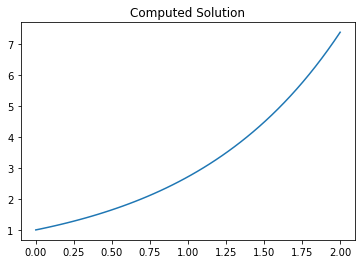

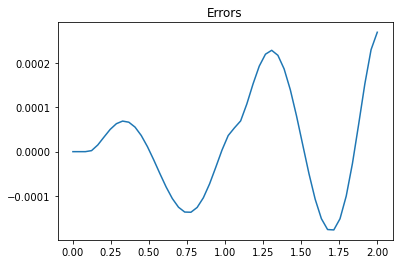

In [16]:
t_plot = np.linspace(a, b)
time_start = time()
ode_solution = solve_ivp(f, [a, b], y_0, t_eval=t_plot)
time_end = time()
time_elapsed = time_end - time_start
print(f"Time take to solve: {time_elapsed} seconds")

# The output is an "object" containing many items; the ones we need for now are t and y.
# More precisely "y" is a 2D array (just as y_0 is always an array)
# though with only a single row for this example, so we just want the 1D array y[0]
# These are extracted as follows:
t = ode_solution.t
y = ode_solution.y[0]

plt.figure()
plt.title("Computed Solution")
plt.plot(t, y)
y_exact = np.exp(t)
errors = y - y_exact
plt.figure()
plt.title("Errors")
plt.plot(t, errors)
plt.show()

Time take to solve: 0.05581021308898926 seconds


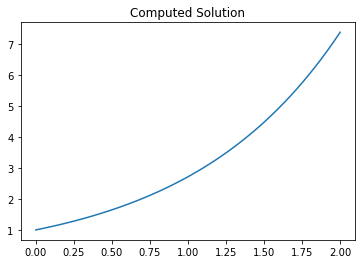

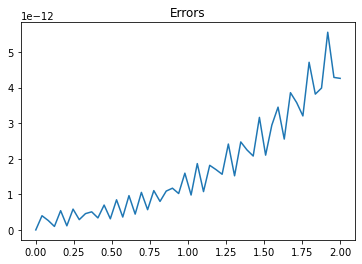

In [17]:
# Increase accuracy requirement.
# "rtol" is a relative error tolerance, defaulting to 1e-3
# "atol" is an absolute error tolerance, defaulting to 1e-3
# It solve to the less demanding of these two,
# so both must be specified to increase accuracy.

t_plot = np.linspace(a, b)

time_start = time()
ode_solution = solve_ivp(f, [a, b], y_0, t_eval=t_plot, rtol=1e-12, atol=1e-12)
time_end = time()
time_elapsed = time_end - time_start
print(f"Time take to solve: {time_elapsed} seconds")

t = ode_solution.t
y = ode_solution.y[0]
plt.figure()
plt.title("Computed Solution")
plt.plot(t, y)
y_exact = np.exp(t)
errors = y - y_exact
plt.figure()
plt.title("Errors")
plt.plot(t, errors)
plt.show()